In [1]:
# Data manipulation and visualisation libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# code so we can import functions
import os
import sys

# import scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# import python scripts we created to help with feature engineering
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.identify_missing_data import identify_missing_data
from src.helpers import identify_highly_correlated_features, one_hot
from src.learning_curve_plot import learning_curve_plot
from src.feature_importance_plot import feature_importance_plot


In [2]:
# load the housing dataframe

housing_df = pd.read_pickle("../data/housing_df.pkl")
housing_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,target
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,RL,62.0,7917.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,8.0,2007.0,175000.0
1456,1457.0,20.0,RL,85.0,13175.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,MnPrv,None,0.0,2.0,2010.0,210000.0
1457,1458.0,70.0,RL,66.0,9042.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,GdPrv,Shed,2500.0,5.0,2010.0,266500.0
1458,1459.0,20.0,RL,68.0,9717.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,0.0,None,None,None,0.0,4.0,2010.0,142125.0


In [3]:
pd.set_option('display.max_columns', None)

housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,target
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,1Fam,7.0,5.0,2003.0,2003.0,BrkFace,196.0,Gd,TA,Gd,TA,No,706.0,0.0,150.0,856.0,Ex,Y,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,0.0,2003.0,RFn,2.0,548.0,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,1Fam,6.0,8.0,1976.0,1976.0,None,0.0,TA,TA,Gd,TA,Gd,978.0,0.0,284.0,1262.0,Ex,Y,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,1.0,1976.0,RFn,2.0,460.0,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,1Fam,7.0,5.0,2001.0,2002.0,BrkFace,162.0,Gd,TA,Gd,TA,Mn,486.0,0.0,434.0,920.0,Ex,Y,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,1.0,2001.0,RFn,2.0,608.0,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,1Fam,7.0,5.0,1915.0,1970.0,None,0.0,TA,TA,TA,Gd,No,216.0,0.0,540.0,756.0,Gd,Y,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,1.0,1998.0,Unf,3.0,642.0,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,1Fam,8.0,5.0,2000.0,2000.0,BrkFace,350.0,Gd,TA,Gd,TA,Av,655.0,0.0,490.0,1145.0,Ex,Y,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,1.0,2000.0,RFn,3.0,836.0,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,250000.0


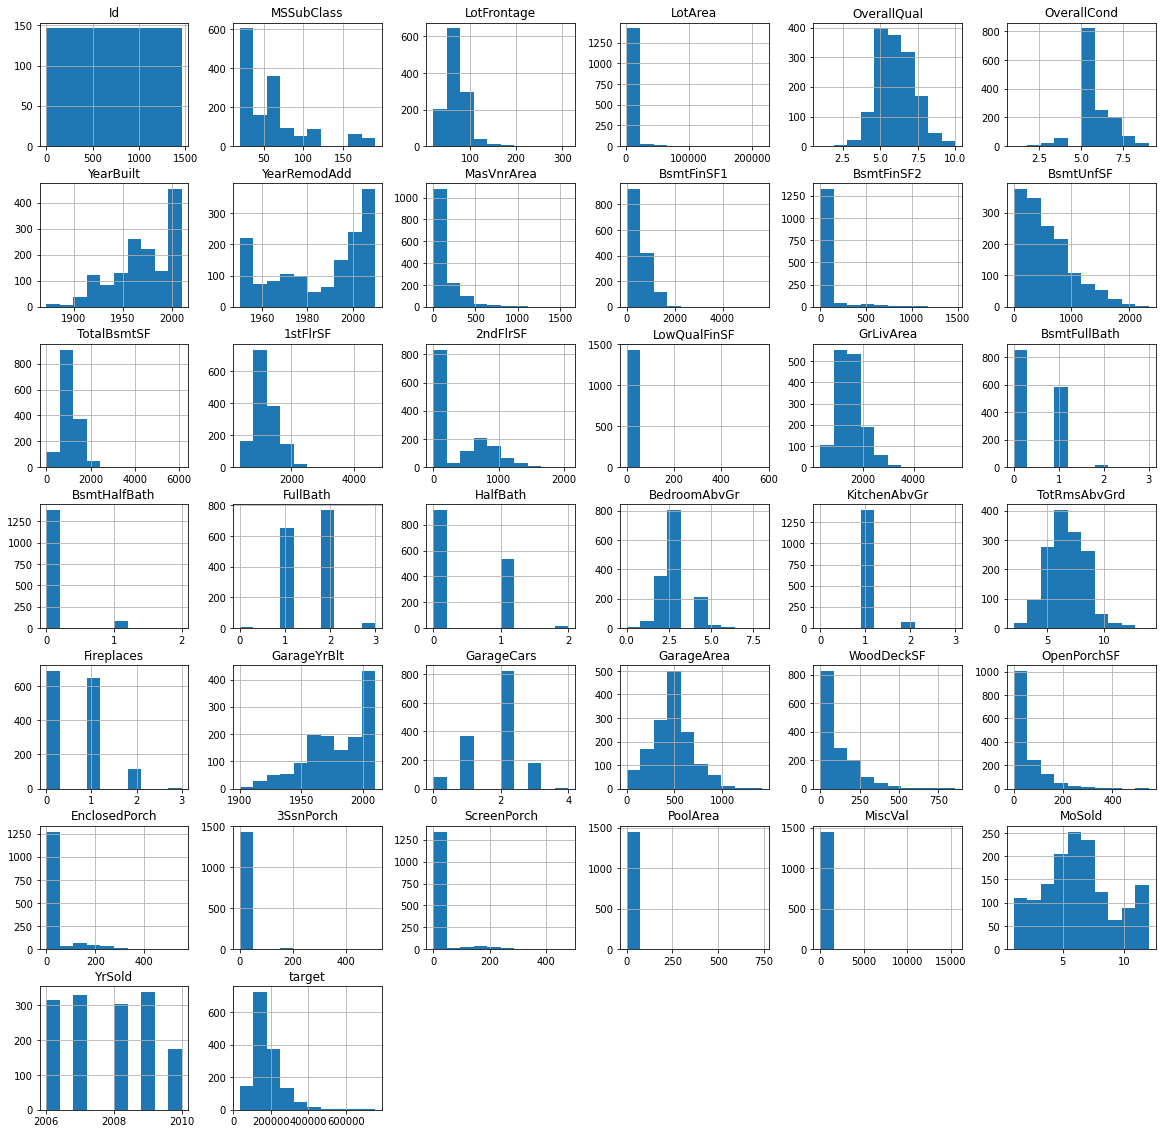

In [4]:
# Distribution of all the numerical features
# skewed data

plt.rcParams["figure.figsize"] = (20,20)

housing_df.hist();

In [5]:
# missing value
missing_value_df = identify_missing_data(housing_df)
missing_value_df[missing_value_df.percent_missing > 0] # only look at features where percent_missing greater than 0


,feature,percent_missing,data_type
0,PoolQC,99.52,object
1,MiscFeature,96.30,object
2,Alley,93.77,object
3,Fence,80.75,object
4,LotFrontage,17.74,float64
5,GarageYrBlt,5.55,float64
6,GarageFinish,5.55,object
7,BsmtExposure,2.60,object
8,BsmtQual,2.53,object
9,BsmtCond,2.53,object


In [6]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 40

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 4
['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [7]:
# drop the features with more than 40% missing data

housing_df.drop(cols_to_drop, axis = 1, inplace = True)

# check the variables are dropped 
housing_df.shape

(1460, 57)

In [8]:
# look for missing data

missing_value_df = identify_missing_data(housing_df)
missing_value_df[missing_value_df.percent_missing > 0] # only look at features where percent_missing greater than 0

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageFinish,5.55,object
2,GarageYrBlt,5.55,float64
3,BsmtExposure,2.60,object
4,BsmtCond,2.53,object
5,BsmtQual,2.53,object
6,MasVnrType,0.55,object
7,MasVnrArea,0.55,float64


In [9]:
# replace all categorical (data type object) missing values with Unknown --- Option 1 

housing_df['GarageFinish'].fillna('Unknown', inplace=True)
housing_df['BsmtExposure'].fillna('Unknown', inplace=True)
housing_df['BsmtCond'].fillna('Unknown', inplace=True)
housing_df['BsmtQual'].fillna('Unknown', inplace=True)
housing_df['MasVnrType'].fillna('Unknown', inplace=True)


In [10]:
# replace all categorical (data type object) missing values with Unknown --- Option 2

missing_value_df = identify_missing_data(housing_df)
missing_value_df_reduced = missing_value_df[missing_value_df.percent_missing > 0]
categorical_cols = list(missing_value_df_reduced[missing_value_df_reduced.data_type == 'object'].feature)
print("number of categorical cols with missing data:", len(categorical_cols))
    
for c in categorical_cols:
    print("replacing missing values for:", c)
    housing_df[c].fillna('Unknown', inplace=True)

number of categorical cols with missing data: 0


In [11]:
# look for missing data

missing_value_df = identify_missing_data(housing_df)
missing_value_df[missing_value_df.percent_missing > 0] # only look at features where percent_missing greater than 0

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageYrBlt,5.55,float64
2,MasVnrArea,0.55,float64


In [12]:
# replace all numerical (data type object) missing values with Unknown --- Option 1 

housing_df['LotFrontage'].fillna(0, inplace=True)
housing_df['GarageYrBlt'].fillna(0, inplace=True)
housing_df['MasVnrArea'].fillna(0, inplace=True)


In [13]:
# replace all numerical missing (data type int, float or bool) values with 0 --- Option 2
missing_value_df = identify_missing_data(housing_df)
missing_value_df_reduced = missing_value_df[missing_value_df.percent_missing > 0]
numerical_cols = list(missing_value_df_reduced[(missing_value_df_reduced.data_type == 'float64') |(missing_value_df_reduced.data_type == 'int64')].feature)

for n in numerical_cols:
    print("replacing missing values for:", n)
    housing_df[n].fillna(0, inplace=True)

In [14]:
# check do we have any missing data left

missing_value_df = identify_missing_data(housing_df)
missing_value_df[missing_value_df.percent_missing > 0]

,feature,percent_missing,data_type


In [15]:
# check the info - 19 variables with object data type that needs encoding

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   float64
 1   MSSubClass     1460 non-null   float64
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   float64
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  OverallQual    1460 non-null   float64
 13  OverallCond    1460 non-null   float64
 14  YearBuilt      1460 non-null   float64
 15  YearRemodAdd   1460 non-null   float64
 16  MasVnrType     1460 non-null   object 
 17  MasVnrArea     1460 non-null   float64
 18  ExterQua

In [16]:
# you can specify all the columns that need encoding

categorical_columns = ['MSZoning', 'Street', 'Alley']

In [17]:
# or..... identify all the non numerical features so we can encode them

categorical_columns = list(housing_df.select_dtypes(['object']).columns)
categorical_columns

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'GarageFinish',
 'PavedDrive']

In [18]:
# check how many columns need encoding

len(categorical_columns)

19

In [19]:
# use the one hot definition - pass in the data frame, and the column names we want to encode

housing_df_w_encoding = one_hot(housing_df, categorical_columns)
housing_df_w_encoding.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unknown,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unknown,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unknown,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unknown,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Unknown,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1


In [20]:
housing_df_w_encoding.shape

(1460, 115)

In [21]:
# identify correlated features

housing_df_w_encoding.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unknown,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unknown,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unknown,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unknown,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Unknown,PavedDrive_N,PavedDrive_P,PavedDrive_Y
Id,1.000000,0.011156,-0.019761,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.013491,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917,-0.024689,-0.012020,0.032453,0.031034,-0.032379,-0.008916,0.008916,-0.025725,-0.037611,0.042541,0.030748,0.015040,0.016800,-0.008845,-0.015657,-0.013324,0.013324,-0.054832,-0.003973,0.015804,0.017722,0.040852,-0.019548,0.034799,-0.029608,-0.017741,-0.022777,0.028174,-0.003186,0.019292,-0.040379,-0.036425,0.024897,0.024760,0.021662,-0.016801,-0.003252,0.018662,-0.011072,0.000915,-0.056698,3.537341e-03,-0.029785,0.022778,-0.048586,-0.008165,-0.002941,0.033795,-0.004431,-0.006690,0.000445,-0.030142,0.009499,-0.004431,0.023245,-0.005336,0.022732,-0.026357,-0.002143,0.006015,0.031442,-0.043248,-0.025126,0.017668,-0.009821,0.009821,-0.004092,-0.010799,0.020933,-0.014973,0.005729,0.009579,-0.007513,-0.013506,-0.012730,0.022269,-0.000355
MSSubClass,0.011156,1.000000,-0.215023,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.080997,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,-0.001762,0.171336,0.058288,-0.343353,0.277750,0.024969,-0.024969,-0.112626,-0.019392,-0.031221,0.122030,0.017973,-0.010676,-0.032201,0.010845,0.022844,-0.022844,-0.063811,-0.044437,0.015217,0.044130,0.067828,0.024344,-0.018716,-0.017184,-0.817461,0.444511,0.150441,0.415159,0.524847,-0.058382,0.053159,-0.023867,-0.019922,-0.016496,-0.028724,0.027165,0.047870,-0.041021,-0.002036,0.072853,-4.465128e-02,-0.016653,0.012015,-0.055495,-0.002796,0.166457,-0.138741,0.015439,0.018708,0.000132,-0.023558,-0.015908,0.015439,0.058105,0.016593,0.003846,-0.061173,0.015555,-0.017200,0.002431,-0.003806,-0.007366,0.021455,0.101774,-0.101774,-0.032687,0.016676,0.022411,-0.010836,0.012199,-0.045044,-0.008807,0.085357,0.069317,-0.025338,-0.047611
LotFrontage,-0.019761,-0.215023,1.000000,0.100739,0.176561,-0.053457,0.036853,0.078686,0.105010,0.076670,-0.009312,0.160829,0.238274,0.245181,0.042549,0.049981,0.220347,0.010514,-0.027856,0.120548,-0.012952,0.144494,0.034425,0.221396,0.044018,0.019317,0.165229,

In [22]:
corr_df = identify_highly_correlated_features(housing_df_w_encoding, correlation_threshold = 0.8)
corr_df

,corr_feature,drop_feature,corrrelation_values
12,BsmtQual_Unknown,BsmtCond_Unknown,1.00
15,CentralAir_N,CentralAir_Y,1.00
3,GarageYrBlt,GarageFinish_Unknown,1.00
6,Street_Grvl,Street_Pave,1.00
8,Utilities_AllPub,Utilities_NoSeWa,1.00
14,BsmtCond_Unknown,BsmtExposure_Unknown,0.99
13,BsmtQual_Unknown,BsmtExposure_Unknown,0.99
7,LotShape_IR1,LotShape_Reg,0.93
9,LandSlope_Gtl,LandSlope_Mod,0.91
10,ExterQual_Gd,ExterQual_TA,0.91


In [23]:
type(corr_df)

pandas.core.frame.DataFrame

In [24]:
cols_to_drop = list(corr_df.drop_feature.unique())
len(cols_to_drop)

17

In [25]:
cols_to_drop

['BsmtCond_Unknown',
 'CentralAir_Y',
 'GarageFinish_Unknown',
 'Street_Pave',
 'Utilities_NoSeWa',
 'BsmtExposure_Unknown',
 'LotShape_Reg',
 'LandSlope_Mod',
 'ExterQual_TA',
 'ExterCond_TA',
 'GarageArea',
 'PavedDrive_Y',
 'TotRmsAbvGrd',
 '1stFlrSF',
 'KitchenQual_TA',
 'BldgType_1Fam',
 'MSZoning_RM']

In [26]:
housing_df_final = housing_df_w_encoding.drop(columns = cols_to_drop)
housing_df_final

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,Street_Grvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unknown,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unknown,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,0.0,2003.0,2.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,1.0,1976.0,2.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,2001.0,2.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,1998.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,2000.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,1999.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,175000.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1456,1457.0,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,2.0,1978.0,2.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,210000.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1457,1458.0,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,2.0,1941.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0

In [27]:
# next steps: build the machine learning model

# check if we have any non numerical data 
housing_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 98 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1460 non-null   float64
 1   MSSubClass          1460 non-null   float64
 2   LotFrontage         1460 non-null   float64
 3   LotArea             1460 non-null   float64
 4   OverallQual         1460 non-null   float64
 5   OverallCond         1460 non-null   float64
 6   YearBuilt           1460 non-null   float64
 7   YearRemodAdd        1460 non-null   float64
 8   MasVnrArea          1460 non-null   float64
 9   BsmtFinSF1          1460 non-null   float64
 10  BsmtFinSF2          1460 non-null   float64
 11  BsmtUnfSF           1460 non-null   float64
 12  TotalBsmtSF         1460 non-null   float64
 13  2ndFlrSF            1460 non-null   float64
 14  LowQualFinSF        1460 non-null   float64
 15  GrLivArea           1460 non-null   float64
 16  BsmtFu

In [28]:
# check for missing data

missing_df = identify_missing_data(housing_df_final)
missing_df[missing_df.percent_missing > 0]

,feature,percent_missing,data_type


In [29]:
# define the target and features

target = housing_df_final["target"]
features = housing_df_final.drop(["target"], axis = 1)

In [30]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.3, 
                                                random_state = 8)


In [31]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (1022, 97)
Shape of y_train (1022,)


In [32]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (438, 97)
Shape of y_test (438,)


In [33]:
# Build a Decision Tree Model

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [34]:
print("first five predicted values:", y_pred_dt[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [223500. 127500.  98300. 176000. 214500.]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


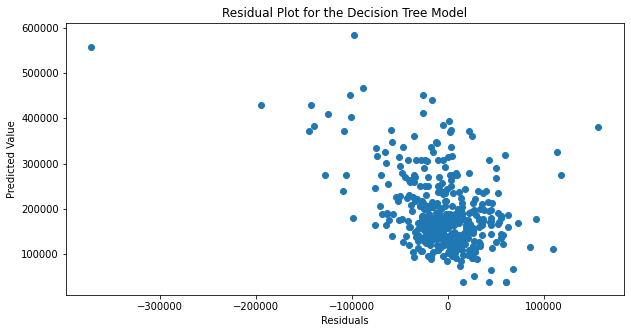

In [35]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_dt

plt.scatter(residuals, y_pred_dt)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [36]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_dt)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_test, y_pred_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error:", round(mse))

R2: 0.67
Mean Absolute Error: 27054
Mean Squared Error: 1743237383


In [37]:
# the evaluation metrics for the model on the training set

y_pred_train_dt = dt.predict(X_train)

r2 = r2_score(y_train, y_pred_train_dt)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_train, y_pred_train_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_dt)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Mean Absolute Error: 0
Mean Squared Error: 0


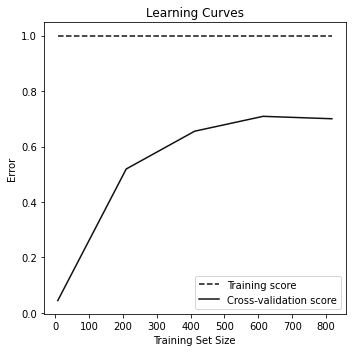

In [38]:
learning_curve_plot(dt, X_train, y_train, scoring = 'r2')

# what can we conclude about the decisiom tree model based on the learning curves?
# overfitting or underfitting
# how or low variance?
# how or low bias?

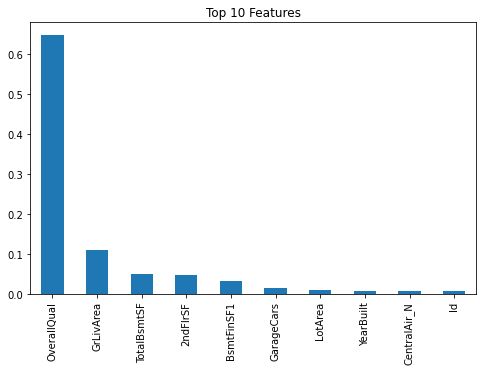

In [39]:
feature_importance_plot(dt, X_train, n = 10)

# what are the most important features?

In [40]:
# Build a Random Forest Model

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [41]:
print("first five predicted values:", y_pred_rf[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [184703.17 129291.5  122564.   149309.39 204316.95]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


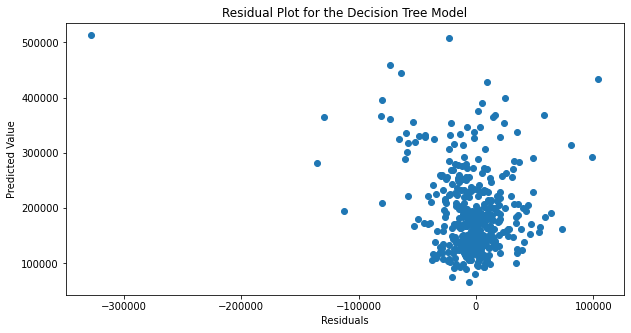

In [42]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_rf

plt.scatter(residuals, y_pred_rf)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [43]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))

R2: 0.83
Mean Absolute Error: 17834
Mean Squared Error: 901033103


In [44]:
# the evaluation metrics for the model on the training set

y_pred_train_rf = rf.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 0.98
Mean Absolute Error: 6738
Mean Squared Error: 120976308


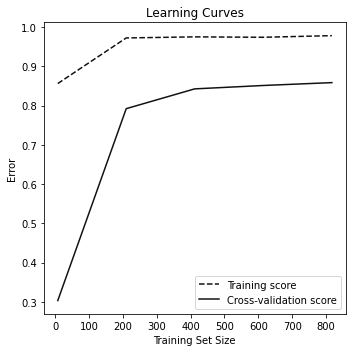

In [45]:
learning_curve_plot(rf, X_train, y_train, scoring = 'r2')

# what can we conclude about the random forest model based on the learning curves? less overfitting

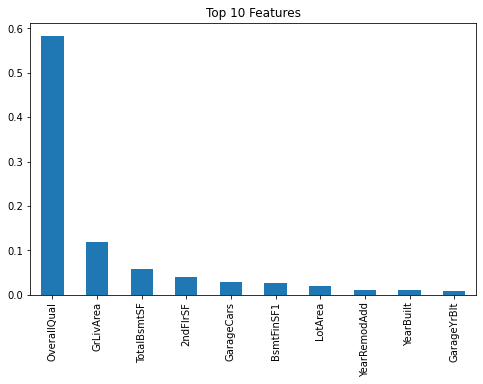

In [46]:
feature_importance_plot(rf, X_train, n = 10)

In [47]:
# Build a XGBoost

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [48]:
print("first five predicted values:", y_pred_xgb[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [188067.17 137273.62 128334.46 137171.77 213628.58]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


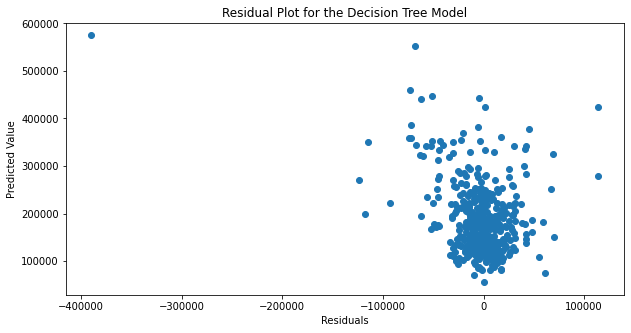

In [49]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_xgb

plt.scatter(residuals, y_pred_xgb)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [50]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_xgb)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_test, y_pred_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", round(mse))

R2: 0.8
Mean Absolute Error: 18769
Mean Squared Error: 1034960310


In [51]:
# the evaluation metrics for the model on the training set

y_pred_train_xgb = xgb.predict(X_train)

r2 = r2_score(y_train, y_pred_train_xgb)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_train, y_pred_train_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_xgb)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Mean Absolute Error: 703
Mean Squared Error: 1049480


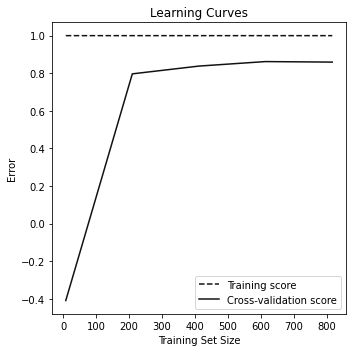

In [52]:
learning_curve_plot(xgb, X_train, y_train, scoring = 'r2')

# what can we conclude about the random forest model based on the learning curves? 

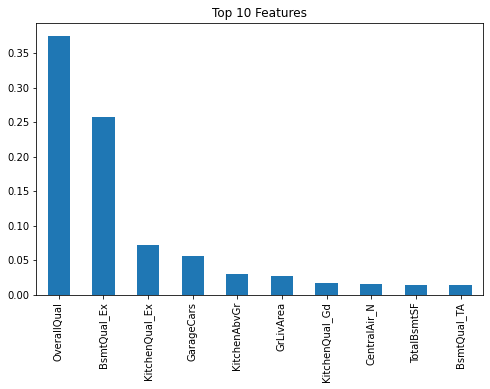

In [53]:
feature_importance_plot(xgb, X_train, n = 10)

In [54]:
# next time - discussion of everyone's evaluation + can we reduce overfitting